In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
from torch import nn
import torch.nn.functional as F
from scipy.stats import linregress

In [3]:
class IMUDataset(Dataset):
    def __init__(self, df, winsize=250, stride=50, transform=None):
        self.X = torch.from_numpy(df[['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']].values)
        self.y = torch.from_numpy(df['rir'].values).to(torch.float32)
        if transform is not None:
            self.X = transform(self.X)
        self.X = self.X.transpose(0, 1).to(torch.float32)
        self.winsize = winsize
        self.stride = stride
        self.len = (self.X.shape[1] - winsize) // stride + 1
    def __len__(self):
        return self.len
    def __getitem__(self, i):
        start = i * self.stride
        end = start + self.winsize
        y = self.y[start:end]#.mean()

        # FOR REGRESSION: y = y.mean() (single value)
        # y = y.mean()

        # FOR BINARY: 1 if y is last rep (< 1.5), 0 if not (single value)
        # y = torch.Tensor([1.0 if y < 1.5 else 0.0])

        # FOR SEGMENTATION: if y changes during window, y = 1 at that point. everywhere else is 0 (<winsize> values)
        y = torch.cat([torch.diff(y) * -1, torch.zeros(1)])
        
        return self.X[:,start:end], y


In [5]:
HZ = 100
df = pd.read_csv('data/data.csv')
session_ids = df['session_id'].unique()
print(len(session_ids))
train_ids, val_ids = train_test_split(session_ids, test_size=0.2, random_state=42)

# winsize_t = 5 # seconds
# stride_t = 0.01 # seconds
# winsize = int(winsize_t * HZ)
# stride = int(stride_t * HZ)
winsize = 256
stride = 1
print(winsize, stride)

train = df.loc[df['session_id'].isin(train_ids), ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']].values
norm = torch.from_numpy(train.mean(axis=0)), torch.from_numpy(train.std(axis=0))

def transform(x):
    return (x - norm[0]) / norm[1]

train_dataset = ConcatDataset([IMUDataset(df[df['session_id'] == session_id], winsize, stride, transform) for session_id in train_ids])
val_dataset = ConcatDataset([IMUDataset(df[df['session_id'] == session_id], winsize, stride, transform) for session_id in val_ids])

len(train_dataset), len(val_dataset)

47
256 1


(132829, 37258)

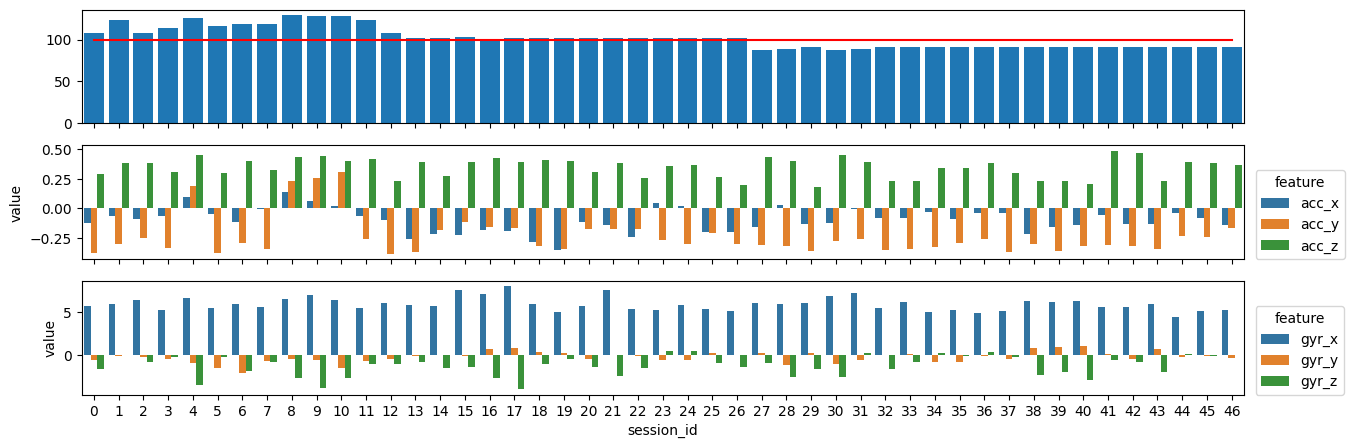

In [110]:
fig,axes = plt.subplots(3,1, sharex=True, figsize=(15,5))
hzs = np.array([(np.diff(df[df['session_id'] == session_id].time.values).mean().round(5)) for session_id in session_ids])
axes[0].bar(session_ids, 1 / hzs)
axes[0].plot(session_ids, np.ones(len(session_ids)) * 100, 'red')


means = df.groupby('session_id', as_index=False).mean(numeric_only=True)
acc_means = means.melt(id_vars='session_id', value_vars=['acc_x', 'acc_y', 'acc_z'], var_name='feature', value_name='value')
gyr_means = means.melt(id_vars='session_id', value_vars=['gyr_x', 'gyr_y', 'gyr_z'], var_name='feature', value_name='value')

sns.barplot(acc_means, x=acc_means['session_id'], y='value', hue='feature', ax=axes[1])
sns.move_legend(axes[1], loc=(1.01, 0))

sns.barplot(gyr_means, x=gyr_means['session_id'], y='value', hue='feature', ax=axes[2])
sns.move_legend(axes[2], loc=(1.01, 0))

In [111]:
# windows = []
window_labels = []
for X, y in train_dataset:
    # windows.append(X.T.numpy())
    window_labels.append(y.item())
plt.hist(window_labels);

RuntimeError: a Tensor with 512 elements cannot be converted to Scalar

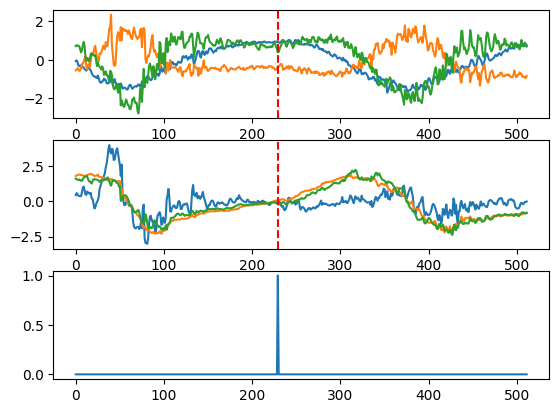

In [112]:
X,y = train_dataset[1300]

fig, axes = plt.subplots(3,1)

axes[0].plot(X[0])
axes[0].plot(X[1])
axes[0].plot(X[2])

axes[1].plot(X[3])
axes[1].plot(X[4])
axes[1].plot(X[5])

axes[2].plot(y)

t = np.where(y == 1)[0]
for ti in t:
    axes[0].axvline(ti, color='red', linestyle='--')
    axes[1].axvline(ti, color='red', linestyle='--')

# plt.suptitle(y.item())

In [113]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(6, 16, 3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv1d(32, 64, 3, padding=1)
        self.ap = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, 512)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.ap(x).squeeze(-1)
        x = self.fc(x)
        return x

In [117]:
class Loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.criterion = nn.MSELoss()
    def forward(self, y_pred, y):
        loss1 = self.criterion(y_pred, y)
        loss2 = self.criterion(y_pred.sum(), y.sum())
        return loss1 + loss2

In [131]:
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
device = 'cuda'
model = ConvNet().to(device)
# criterion = nn.MSELoss()
criterion = Loss()
# criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)

In [132]:
X,y = next(iter(trainloader))
model(X.to(device)).shape

torch.Size([32, 512])

In [133]:
def train(epochs, model, trainloader, valloader, criterion, optimizer):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X, y in trainloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(trainloader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in valloader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                loss = criterion(y_pred, y)
                val_loss += loss.item()
        val_losses.append(val_loss / len(valloader))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        print(f'Epoch {epoch} train loss: {train_losses[-1]}, val loss: {val_losses[-1]}')

        plt.plot(train_losses, label='Train')
        plt.plot(val_losses, label='Val')
        plt.legend()
        plt.savefig('loss.png')
        plt.close()
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Val')
    plt.legend()
    plt.show()
    return train_losses, val_losses

In [122]:
# data aug - stride of 1

In [123]:
train_losses, val_losses = train(100, model, trainloader, valloader, criterion, optimizer)

Epoch 0 train loss: 268.8681598239179, val loss: 292.58819601353366
Epoch 1 train loss: 47.302186367004595, val loss: 356.3617788915906
Epoch 2 train loss: 64.219544409217, val loss: 405.65933463621116
Epoch 3 train loss: 63.20242874330106, val loss: 394.92007578054773
Epoch 4 train loss: 65.95098664538789, val loss: 317.01196734423695
Epoch 5 train loss: 64.16829841648563, val loss: 297.2617459823172
Epoch 6 train loss: 55.65652525085304, val loss: 531.6053906157407
Epoch 7 train loss: 67.3488689747853, val loss: 351.52300971757404
Epoch 8 train loss: 62.311603333880086, val loss: 324.5709468043026
Epoch 9 train loss: 57.59399039659834, val loss: 750.425792879425
Epoch 10 train loss: 49.804104009604636, val loss: 301.2538622089059
Epoch 11 train loss: 66.21423940974486, val loss: 324.6505145478227
Epoch 12 train loss: 69.07497829735456, val loss: 341.97196808325896
Epoch 13 train loss: 74.40718469998411, val loss: 386.66534512281856
Epoch 14 train loss: 63.62087211135281, val loss: 29

KeyboardInterrupt: 

In [129]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')

NameError: name 'train_losses' is not defined

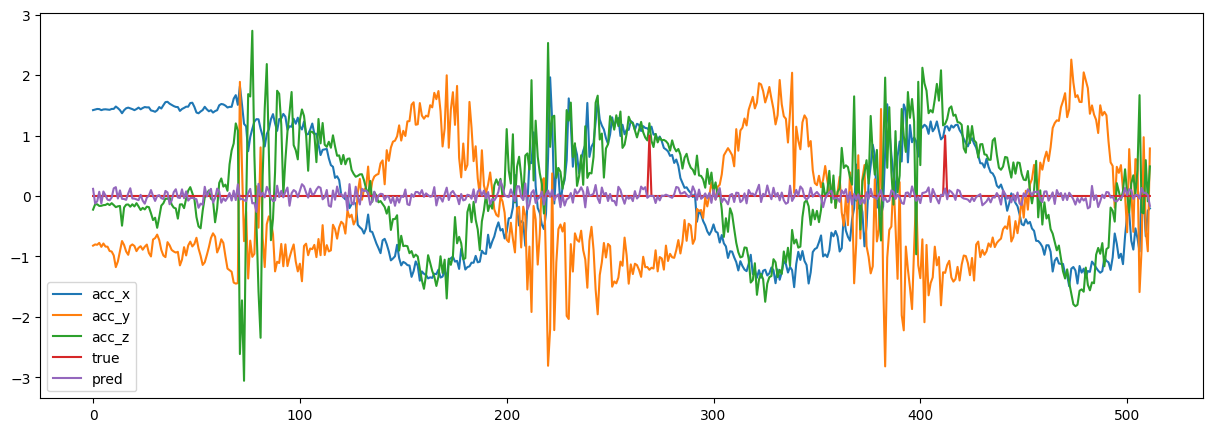

In [ ]:
X,y = next(iter(valloader))
model.eval()
with torch.no_grad():
    ypred = model(X.to(device)).cpu()

plt.figure(figsize=(15,5))
plt.plot(X[0,0].numpy(), label='acc_x')
plt.plot(X[0,1].numpy(), label='acc_y')
plt.plot(X[0,2].numpy(), label='acc_z')
plt.plot(y[0].numpy(), label='true')
plt.plot(ypred[0].numpy(), label='pred')
plt.legend()

In [272]:
ys = []
ypreds = []
model.eval()
with torch.no_grad():
    for X, y in valloader:
        ypred = model(X).squeeze()
        ys.append(y)
        ypreds.append(ypred)
ys = torch.cat(ys)
ypreds = torch.cat(ypreds)

Text(0.5, 1.0, 'R^2: 0.03')

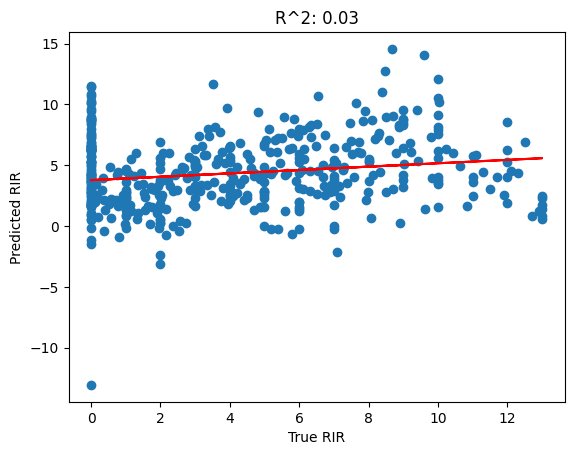

In [276]:
regr = linregress(ys, ypreds)
plt.scatter(ys, ypreds)
plt.plot(ys, regr.intercept + regr.slope * ys, color='red')
plt.xlabel('True RIR')
plt.ylabel('Predicted RIR')
plt.title(f'R^2: {regr.rvalue**2:.2f}')